<a href="https://colab.research.google.com/github/Sonal12061/LangGraph_Implementations/blob/main/Collabrative_Risk_Register_Builder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisites

## Installing the packages

In [1]:
!pip -q install --upgrade redis chromadb langchain langgraph \
    huggingface_hub pydantic langchain-huggingface langchain_community

## Running Redis locally

In [2]:
!apt-get update && \
apt-get install -y redis-server && \
redis-server --daemonize yes

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [3]:
# import subprocess, time, os, sys, textwrap

# # Daemonise Redis so the notebook keeps running.
# subprocess.Popen(["redis-server", "--daemonize", "yes"])
# time.sleep(1)  # give it a heartbeat to start

## Quick health checks for redis and chromadb

In [4]:
import redis, chromadb

try:
    r = redis.Redis(host="localhost", port=6379, db=0)
    r.ping()
    print("✅ Redis: up & reachable")
except redis.exceptions.ConnectionError as e:
    sys.exit("❌ Redis failed to start ‑ check the logs")

print(f"✅ ChromaDB imported (version {chromadb.__version__})")

✅ Redis: up & reachable
✅ ChromaDB imported (version 1.0.15)


In [5]:
from google.colab import userdata
from huggingface_hub import login

HF_TOKEN = userdata.get('HF_TOKEN')

## Dataset Creation

In [6]:
# import pathlib, textwrap, random, datetime, json

# WORK_DIR = pathlib.Path("/content/workpapers")
# WORK_DIR.mkdir(parents=True, exist_ok=True)

# today = datetime.date.today().isoformat()

# samples = {
#     "CTRL001_FINANCE.txt": f"""
#         [Control Narrative]
#         All capital expenditure above $50 k must be approved by both the Plant
#         Manager and the Finance Controller before booking.

#         [Testing Evidence]
#         • PO #5312 for a 15 kV circuit breaker ($62 880) was approved only by
#           the Plant Manager.

#         [Implication]
#         Potential mis‑classification of CapEx and overstatement of fixed assets.
#         (Sample extracted {today})
#     """,

#     "CTRL002_COMPLIANCE.txt": f"""
#         [Control Narrative]
#         Employees handling SF6 gas must hold a current EPA 608 certificate.

#         [Testing Evidence]
#         Ten out of 42 maintenance staff have certificates expired > 90 days.

#         [Implication]
#         Non‑compliance with US EPA Subpart LL; risk of regulatory fines.
#     """,

#     "CTRL003_MIXED.txt": f"""
#         [Control Narrative]
#         Energy trading deals above 75 MWh require same‑day confirmation by the
#         Risk Management desk.

#         [Testing Evidence]
#         Two trades (Deal IDs TX412 & TX415) > $1 M each remained unconfirmed for
#         three days due to holiday staffing gaps.

#         [Implication]
#         • Financial: valuation uncertainty may misstate P&L by > $300 k.
#         • Compliance: breach of ISO 37001 “timely confirmation” clause.
#     """,

#     "CTRL004_FINANCE.txt": f"""
#         [Control Narrative]
#         Monthly depreciation runs use a system‑generated economic life matrix.

#         [Testing Evidence]
#         The matrix still contains legacy assets with 35‑year lives which should
#         have been revised to 25 years under IFRS 16.

#         [Implication]
#         Under‑depreciation may overstate 2025 EBITDA by up to $450 k.
#     """,

#     "CTRL005_COMPLIANCE.txt": f"""
#         [Control Narrative]
#         All SCADA access logs must be retained for seven years.

#         [Testing Evidence]
#         Log retention policy set to 365 days; oldest log available dated
#         {today} minus 361 days.

#         [Implication]
#         Violates NERC CIP‑007‑6 R4; possible mandatory mitigation and penalties.
#     """,
# }

# for fname, body in samples.items():
#     (WORK_DIR / fname).write_text(textwrap.dedent(body).strip())
#     print(f"📝  Created {fname}")

# print(f"\n✅ 5 synthetic workpapers saved to {WORK_DIR}")


## Hugging Face token sanity‑check  

In [7]:
from google.colab import userdata
from huggingface_hub import login

HF_TOKEN = userdata.get('HF_TOKEN')
try:
  login(token=HF_TOKEN)
  print("✨ Environment ready. Proceed to agent code.")
except:
  print("❌ HF_TOKEN is not set.")


✨ Environment ready. Proceed to agent code.


# Creating the Extractor Agent

## Importing Necessary Libraries

In [8]:
import os, pathlib, re, json, itertools, time, textwrap, redis, uuid
from typing import TypedDict, List

from langchain.text_splitter import RecursiveCharacterTextSplitter
from huggingface_hub import InferenceClient

import chromadb
from chromadb.utils import embedding_functions

from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

## Config Setup

In [9]:
WORK_DIR          = pathlib.Path("/content/workpapers")   # <- drop files here
REDIS_STREAM      = "para_ready"
CHROMA_DIR        = "/content/chroma_store"
CHROMA_COLLECTION = "audit_paragraphs"

BATCH_SIZE        = 10        # paragraphs per embedding request
EMBED_MODEL       = "sentence-transformers/all-MiniLM-L6-v2"
LLM_EMBED_KWARGS  = {"device": "cpu"}   # runs quickly on Colab CPU
COLLECTION_NAME   = "audit_paragraphs"

r = redis.Redis(host="localhost", port=6379, db=0, decode_responses=True)
hf = InferenceClient(model=EMBED_MODEL, token=HF_TOKEN)

## ChromaDB client + Collection

In [10]:
client = chromadb.PersistentClient(path=CHROMA_DIR)
# Iterate through all the collections to check for the collection name
if COLLECTION_NAME not in [c.name for c in client.list_collections()]:
    # If collection doesnot exists create the collection with the same name
    coll = client.create_collection(COLLECTION_NAME)
else:
    # Fetch the object of the collection
    coll = client.get_collection(COLLECTION_NAME)

## Helper Function and Recursive Splitter

In [11]:
# This code functions reads .txt/.md files, splits them into overlapping chunks, batches those chunks, and tags each with a control ID so downstream steps know which source (or audit control) they came from.

# The "paper cutter"
splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=50,
    separators=["\n\n", "\n", ".", " ", ""],
)
# Repalce words like Control‑42_report.docx to CTRL42
def extract_control_id(fname: str) -> str:
    m = re.search(r"(CTRL|CONTROL)[-_ ]?(\d+)", fname.upper())
    return f"CTRL{m.group(2)}" if m else pathlib.Path(fname).stem.upper()

# Helps to read ONLY .txt and .md files
def load_text(fp: pathlib.Path) -> str:
    if fp.suffix.lower() in {".txt", ".md"}:
        return fp.read_text(errors="ignore")
    raise ValueError(f"Unsupported file type: {fp.name}")

# Creating batches of lists/strings
def batched(iterable, n):
    it = iter(iterable)
    while (chunk := list(itertools.islice(it, n))):
        yield chunk

## Audit State

In [12]:
class AuditState(TypedDict):
    folder: str
    processed: int
    fin_last_id: str
    fin_scored: int
    comp_last_id: str
    comp_scored: int
    resolved: List[str]

## Extractor Node

In [13]:
def extractor_node(state: AuditState) -> AuditState:
    folder = pathlib.Path(state["folder"])
    processed, all_paras, all_ids, all_meta = 0, [], [], []
    # Check if all the files in the folder is .txt or .md
    for fp in folder.glob("**/*.*"):
        try:
            raw = load_text(fp)
        except Exception as e:
            print(f"⏭️  Skipped {fp.name}: {e}")
            continue

        ctrl_id = extract_control_id(fp.name)
        paragraphs = splitter.split_text(raw)
        processed += len(paragraphs)

        for idx, para in enumerate(paragraphs):
            # Every paragraph gets announced by the Redis para_ready.
            entry_id = r.xadd(REDIS_STREAM, {
                "control_id": ctrl_id,
                "doc_name": fp.name,
                "para_idx": idx,
                "text": para.strip(),
            })
            # for batch embedding
            uid = f"{ctrl_id}_{idx}"
            all_paras.append(para.strip())
            all_ids.append(uid)
            all_meta.append({"control_id": ctrl_id, "doc_name": fp.name, "idx": idx})

        print(f"📄 {fp.name}: {len(paragraphs)} paragraphs emitted.")

    # ── 3a. Batch‑call HF embeddings & upsert to Chroma ──────────
    for texts_chunk, ids_chunk, meta_chunk in zip(
        batched(all_paras, BATCH_SIZE),
        batched(all_ids,  BATCH_SIZE),
        batched(all_meta, BATCH_SIZE),
        ):

        vectors = hf.feature_extraction(texts_chunk, model=EMBED_MODEL)
        # feature_extraction returns list[list[float]]
        coll.add(
            ids=ids_chunk,
            documents=texts_chunk,
            metadatas=meta_chunk,
            embeddings=vectors,
        )

    print(f"\n✅ Extracted {processed} paragraphs → {len(all_paras)} embeddings stored.")
    return {"folder": str(folder), "processed": processed}

# Creating the Fin-Risk Agent

## Importing Libraries

In [14]:
import redis, re, json, random
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

## Runtime config

In [15]:
r = redis.Redis(host="localhost", port=6379, db=0, decode_responses=True)
REDIS_STREAM = "para_ready"
RISK_HASH_TPL = "risk:{}"

## Helper Function

In [16]:
FIN_KEYWORDS = [
    "invoice", "capital", "expense", "depreciation", "revenue",
    "EBIT", "capex", "$", "cash", "trade", "P&L", "valuation"
]
def is_finance_para(txt: str) -> bool:
    txt_low = txt.lower()
    return any(kw in txt_low for kw in FIN_KEYWORDS)

In [17]:
import os, re, json, random, textwrap
from huggingface_hub import InferenceClient


DRY_RUN = False                           # flip True to stub out API calls

if not DRY_RUN:
    client = InferenceClient(
        model="mistralai/Mistral-7B-Instruct-v0.2",
        token=HF_TOKEN,
        timeout=120,            # seconds
    )
else:
    client = None              # placeholder when DRY_RUN

def analyze_with_mistral(paragraph: str, *, role: str = "financial") -> dict:
    """
    Returns
      { "level": "Low|Medium|High",
        "rationale": "<≤50‑word explanation>" }
    `role` = "financial" | "compliance"
    """
    if DRY_RUN:
        return {
            "level": random.choice(["Low", "Medium", "High"]),
            "rationale": f"Stub rationale for {role} (DRY_RUN).",
        }

    rubric = (
        "material financial mis‑statement"
        if role == "financial"
        else "regulatory or compliance breach"
    )

    system_msg = {
        "role": "system",
        "content": (
            f"You are a senior {role} auditor. "
            "When given a paragraph, assess the risk of "
            f"{rubric}. Respond ONLY with JSON:"
            ' {"level": "...", "rationale": "..."}'
        ),
    }
    user_msg = {
        "role": "user",
        "content": textwrap.dedent(f"""
            Paragraph:
            \"\"\"{paragraph}\"\"\"
        """).strip(),
    }

    resp = client.chat_completion(
        messages=[system_msg, user_msg],
        temperature=0.2,
        max_tokens=150,
    )
    raw = resp.choices[0].message.content

    match = re.search(r"\{.*\}", raw, re.S)
    if not match:
        raise ValueError("❌ JSON not found in model output:\n" + raw[:500])

    return json.loads(match.group())


## Fin Risk Node Definition

In [18]:
from __main__ import analyze_with_mistral      # helper defined earlier

def fin_risk_node(state: AuditState) -> AuditState:
    last_id   = state.get("fin_last_id", "0-0")   # keep namespace “fin_…”
    scored    = state.get("fin_scored", 0)
    new_id    = last_id
    control_ids_processed = {}
    # read up to 100 events > last_id
    entries = r.xrange(REDIS_STREAM, min=last_id, max="+", count=100)
    print(f"These are the entries in the node: {entries}")
    if entries and entries[0][0] == last_id:
        entries = entries[1:]

    for ev_id, ev in entries:
        txt = ev["text"]
        if not is_finance_para(txt):
            new_id = ev_id   # checkpoint even if skipped
            continue
        if ev["control_id"] not in control_ids_processed:
          control_ids_processed[ev["control_id"]] = True
          verdict = analyze_with_mistral(txt, role="financial")
          # optimistic write into shared hash
          hkey = RISK_HASH_TPL.format(ev["control_id"])
          print(f"Here is the hkey {hkey}")
          while True:
              try:
                  with r.pipeline() as pipe:
                      pipe.watch(hkey)
                      lock = int(pipe.hget(hkey, "lock_version") or 0)
                      pipe.multi()
                      pipe.hset(hkey, mapping={
                          "finance.level": verdict["level"],
                          "finance.rat":   verdict["rationale"],
                          "lock_version":  lock + 1,
                      })
                      pipe.execute()
                      break
              except redis.WatchError:
                  continue   # retry on collision

          scored += 1
          new_id = ev_id
        else:
          continue
    # --- inside fin_risk_node ---------------------------------------
    delta = scored - state.get("fin_scored", 0)   # <- use fin_scored
    print("✅ Fin‑Risk analysed", delta, "new paragraphs." if delta else
          "⏸️  Fin‑Risk: no finance paragraphs to score.")

    state.update({"fin_last_id": new_id, "fin_scored": scored})
    return state

# Creating the Comp_Risk Agent

## Helper Functions

In [19]:
# ── 1. Shared constants & Redis ---------------------------------
r = redis.Redis(host="localhost", port=6379, db=0, decode_responses=True)
STREAM        = "para_ready"
RISK_HASH_TPL = "risk:{}"

# ── 2. Compliance keyword filter --------------------------------
COMP_KEYWORDS = [
    "gdpr", "regulation", "compliance", "certificate",
    "epa", "nerc", "iso", "policy", "fine", "penalty",
]

def is_compliance_para(txt: str) -> bool:
    lower = txt.lower()
    return any(kw in lower for kw in COMP_KEYWORDS)

## Comp Risk node

In [20]:
def comp_risk_node(state: AuditState) -> AuditState:
    last_id   = state.get("comp_last_id", "0-0")
    scored    = state.get("comp_scored", 0)
    new_id    = last_id
    control_ids_processed = {}

    entries = r.xrange(STREAM, min=last_id, max="+", count=100)
    print(f"Here are the entries {entries}")
    if entries and entries[0][0] == last_id:
        entries = entries[1:]

    for ev_id, ev in entries:
        txt = ev["text"]
        if not is_compliance_para(txt):
            new_id = ev_id
            continue
        if ev["control_id"] not in control_ids_processed:
          control_ids_processed[ev["control_id"]] = True
          verdict = analyze_with_mistral(txt, role="compliance")

          hkey = RISK_HASH_TPL.format(ev["control_id"])
          while True:
              try:
                  with r.pipeline() as pipe:
                      pipe.watch(hkey)
                      lock = int(pipe.hget(hkey, "lock_version") or 0)
                      pipe.multi()
                      pipe.hset(hkey, mapping={
                          "compliance.level": verdict["level"],
                          "compliance.rat":   verdict["rationale"],
                          "lock_version":     lock + 1,
                      })
                      pipe.execute()
                      break
              except redis.WatchError:
                  continue  # retry on collision

          scored += 1
          new_id = ev_id
        else:
          continue

    delta = scored - state.get("comp_scored", 0)
    print("✅ Comp‑Risk analysed", delta, "new paragraphs." if delta else
          "⏸️  Comp‑Risk: no compliance paragraphs to score.")

    state.update({"comp_last_id": new_id, "comp_scored": scored})
    return state

# Creating the Resolver Agent

## Helper Function

In [29]:


def higher_severity(a: str, b: str) -> str:
  SEVERITY_RANK = {"Low": 1, "Medium": 2, "High": 3}
  if a == "None" and b == "None":
        return "None"

    # 2. one missing
  if a == "None":
      return b
  if b == "None":
      return a

    # 3. both present – pick the higher‑ranked one
  if (SEVERITY_RANK[a] >= SEVERITY_RANK[b]):
    return a
  else:
    return b

## Resolver Node function

In [30]:
def resolver_node(state: AuditState) -> AuditState:
    resolved_set = set(state.get("resolved", []))
    new_resolved = []

    for hkey in r.scan_iter("risk:*"):
        ctrl_id = hkey.split("risk:")[1]
        if ctrl_id in resolved_set:
            continue

        h = r.hgetall(hkey)
        if not ("finance.level" in h and "compliance.level" in h):
            continue  # still waiting for both views

        fin_lvl, comp_lvl = h["finance.level"], h["compliance.level"]
        fin_rat, comp_rat = h["finance.rat"],  h["compliance.rat"]
        print(f"This is the {fin_lvl} and this is the {comp_lvl} ")
        # 4a. Fast rules
        if fin_lvl != comp_lvl:
            final_lvl = higher_severity(fin_lvl, comp_lvl)
            merged_rat = (
                f"Finance rated {fin_lvl}; Compliance rated {comp_lvl}. "
                f"Taking higher severity '{final_lvl}'. "
                f"Key points: {fin_rat} | {comp_rat}"
            )
        else:
            # Same severity → check rationale similarity
            diff_len = abs(len(fin_rat) - len(comp_rat))
            if diff_len > 30:   # substantial difference → ask LLM
                resp = analyze_with_mistral(
                    f"Finance rationale: {fin_rat}\n\n"
                    f"Compliance rationale: {comp_rat}\n\n"
                    "Merge these into one concise paragraph "
                    "≤60 words and keep the 'High/Medium/Low' level unchanged.",
                    role="financial",  # role doesn't matter here
                )
                final_lvl   = fin_lvl
                merged_rat  = resp["rationale"]
            else:
                final_lvl  = fin_lvl
                merged_rat = fin_rat  # good enough

        # 4b. Write back final fields
        while True:
            try:
                with r.pipeline() as pipe:
                    pipe.watch(hkey)
                    lock = int(pipe.hget(hkey, "lock_version") or 0)
                    pipe.multi()
                    pipe.hset(hkey, mapping={
                        "final.level": final_lvl,
                        "final.rationale": merged_rat,
                        "lock_version":    lock + 1,
                    })
                    pipe.execute()
                    break
            except redis.WatchError:
                continue  # retry on race

        # 4c. Embed merged rationale into Chroma (once)
        embed = hf.feature_extraction([merged_rat])[0]
        coll.add(
            ids        = [f"{ctrl_id}_final"],
            documents  = [merged_rat],
            metadatas  = [{"control_id": ctrl_id, "type": "merged"}],
            embeddings = [embed],
        )

        new_resolved.append(ctrl_id)

    if new_resolved:
        print("✅ Resolver merged", len(new_resolved), "controls:", new_resolved)
    else:
        print("⏸️  Resolver: nothing new to merge.")

    state.setdefault("resolved", []).extend(new_resolved)
    return state


In [31]:
# ── 0. Prereqs already run earlier ───────────────────────────────
# • extractor_node, fin_risk_node, comp_risk_node, resolver_node
# • helper analyze_with_mistral(), Redis client, Chroma client, etc.

# ── 1. One shared AuditState for all nodes ───────────────────────
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

class AuditState(TypedDict):
    folder: str
    processed: int
    fin_last_id: str
    fin_scored: int
    comp_last_id: str
    comp_scored: int
    resolved: List[str]

# ── 2. Build one graph (reuse SAME MemorySaver) ──────────────────
ckpt = MemorySaver()                    # ← keep exactly one saver

g = StateGraph(AuditState)
g.add_node("extractor", extractor_node)
g.add_node("fin_risk",  fin_risk_node)
g.add_node("comp_risk", comp_risk_node)
g.add_node("resolver",  resolver_node)

g.set_entry_point("extractor")
g.add_edge("extractor", "fin_risk")
g.add_edge("fin_risk",  "comp_risk")
g.add_edge("comp_risk", "resolver")
g.add_edge("resolver",  END)

audit_graph = g.compile(checkpointer=ckpt)

# ── 3. FIRST run  →  pass initial state + thread_id  ─────────────
cfg = {"configurable": {"thread_id": "extract24_session"}}

bootstrap = AuditState(
    folder       = str(WORK_DIR),  # "/content/workpapers"
    processed    = 0,
    fin_last_id  = "0-0",
    fin_scored   = 0,
    comp_last_id = "0-0",
    comp_scored  = 0,
    resolved     = [],
)

audit_graph.invoke(bootstrap, config=cfg)

# ── 4. Subsequent runs in the same kernel  →  empty dict ─────────
# audit_graph.invoke({}, config=cfg)


📄 CTRL001_FINANCE.txt: 1 paragraphs emitted.
📄 CTRL005_COMPLIANCE.txt: 1 paragraphs emitted.
📄 CTRL004_FINANCE.txt: 1 paragraphs emitted.
📄 CTRL003_MIXED.txt: 1 paragraphs emitted.
📄 CTRL002_COMPLIANCE.txt: 1 paragraphs emitted.

✅ Extracted 5 paragraphs → 5 embeddings stored.
These are the entries in the node: [('1753252805802-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753252805803-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for se

{'folder': '/content/workpapers',
 'processed': 5,
 'fin_last_id': '1753262024868-2',
 'fin_scored': 3,
 'comp_last_id': '1753262024868-0',
 'comp_scored': 3,
 'resolved': ['CTRL003']}

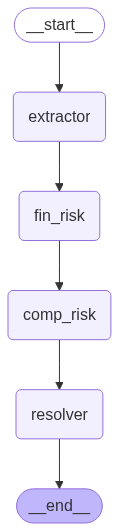

In [32]:

from IPython.display import Image, display

try:
    display(Image(audit_graph .get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    raise(Exception)


In [28]:
import redis, pandas as pd, pprint
from langchain.text_splitter import RecursiveCharacterTextSplitter

# ── 1. Pull all risk hashes into a DataFrame ─────────────────────
r = redis.Redis(host="localhost", port=6379, db=0, decode_responses=True)

rows = []
for hkey in r.scan_iter("risk:*"):
    ctrl_id = hkey.split("risk:")[1]
    h = r.hgetall(hkey)
    rows.append({
        "control_id":      ctrl_id,
        "finance.level":   h.get("finance.level"),
        "compliance.level":h.get("compliance.level"),
        "final.level":     h.get("final.level"),
        "final.rationale": h.get("final.rationale", "")[:120] + "…",
    })

df = pd.DataFrame(rows).sort_values("control_id").reset_index(drop=True)
pd.set_option("display.max_colwidth", None)
display(df)                  # Colab shows a nice table

# ── 2. Semantic search helper over Chroma ────────────────────────
def semantic_search(query: str, k: int = 3):
    print(f"\n🔎 Top {k} hits for: “{query}”")
    res = coll.query(
        query_texts=[query],
        n_results=k,
        include=["documents", "metadatas", "distances"],
    )
    for doc, meta, dist in zip(
        res["documents"][0], res["metadatas"][0], res["distances"][0]
    ):
        print(f"\n— Distance {dist:.3f} | Control {meta.get('control_id')}")
        pprint.pprint(doc)

# Example query:
semantic_search("GDPR violation overdue certificates", k=2)


,control_id,finance.level,compliance.level,final.level,final.rationale
0,CTRL001,High,None,None,…
1,CTRL002,None,High,None,…
2,CTRL003,High,High,High,"The unconfirmed trades worth over $1M each and valued over $300k collectively, remaining unconfirmed for three days due …"
3,CTRL004,High,None,None,…
4,CTRL005,None,High,None,…



🔎 Top 2 hits for: “GDPR violation overdue certificates”

— Distance 1.110 | Control CTRL002
('[Control Narrative]\n'
 'Employees handling SF6 gas must hold a current EPA\xa0608 certificate.\n'
 '\n'
 '[Testing Evidence]\n'
 'Ten out of 42 maintenance staff have certificates expired >\xa090\u202f'
 'days.\n'
 '\n'
 '[Implication]\n'
 'Non‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.')

— Distance 1.472 | Control CTRL003
('[Control Narrative]\n'
 'Energy trading deals above 75\u202fMWh require same‑day confirmation by the\n'
 'Risk Management desk.\n'
 '\n'
 '[Testing Evidence]\n'
 'Two trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained '
 'unconfirmed for\n'
 'three days due to holiday staffing gaps.\n'
 '\n'
 '[Implication]\n'
 '• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n'
 '• Compliance: breach of ISO\xa037001 “timely confirmation” clause.')


In [26]:
# 1. How many paragraph events?
r.xlen("para_ready")

# 2. Look at one merged hash
r.hgetall("risk:CTRL003")

# 3. Confirm merged rationale stored in Chroma
coll.count(), coll.get(ids=["CTRL003_final"])


(6,
 {'ids': ['CTRL003_final'],
  'embeddings': None,
  'documents': ["The unconfirmed trades worth over $1M each and valued over $300k collectively, remaining unconfirmed for three days due to holiday staffing gaps, pose a significant risk of material financial misstatement. This could result in valuation uncertainty and potential misstatement of P&L. Additionally, there is a compliance risk as this situation may represent a breach of ISO 37001 'timely confirmation' clause."],
  'uris': None,
  'included': ['metadatas', 'documents'],
  'data': None,
  'metadatas': [{'type': 'merged', 'control_id': 'CTRL003'}]})

In [27]:
x = [('1753252805802-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753252805803-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'}), ('1753252805804-0', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nMonthly depreciation runs use a system‑generated economic life matrix.\n\n[Testing Evidence]\nThe matrix still contains legacy assets with 35‑year lives which should\nhave been revised to 25\xa0years under IFRS\xa016.\n\n[Implication]\nUnder‑depreciation may overstate 2025\xa0EBITDA by up to $450\u202fk.'}), ('1753252805804-1', {'control_id': 'CTRL003', 'doc_name': 'CTRL003_MIXED.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEnergy trading deals above 75\u202fMWh require same‑day confirmation by the\nRisk Management desk.\n\n[Testing Evidence]\nTwo trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained unconfirmed for\nthree days due to holiday staffing gaps.\n\n[Implication]\n• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n• Compliance: breach of ISO\xa037001 “timely confirmation” clause.'}), ('1753252805805-0', {'control_id': 'CTRL002', 'doc_name': 'CTRL002_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEmployees handling SF6 gas must hold a current EPA\xa0608 certificate.\n\n[Testing Evidence]\nTen out of 42 maintenance staff have certificates expired >\xa090\u202fdays.\n\n[Implication]\nNon‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.'}), ('1753252855184-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753252855185-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'}), ('1753252855186-0', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nMonthly depreciation runs use a system‑generated economic life matrix.\n\n[Testing Evidence]\nThe matrix still contains legacy assets with 35‑year lives which should\nhave been revised to 25\xa0years under IFRS\xa016.\n\n[Implication]\nUnder‑depreciation may overstate 2025\xa0EBITDA by up to $450\u202fk.'}), ('1753252855186-1', {'control_id': 'CTRL003', 'doc_name': 'CTRL003_MIXED.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEnergy trading deals above 75\u202fMWh require same‑day confirmation by the\nRisk Management desk.\n\n[Testing Evidence]\nTwo trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained unconfirmed for\nthree days due to holiday staffing gaps.\n\n[Implication]\n• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n• Compliance: breach of ISO\xa037001 “timely confirmation” clause.'}), ('1753252855186-2', {'control_id': 'CTRL002', 'doc_name': 'CTRL002_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEmployees handling SF6 gas must hold a current EPA\xa0608 certificate.\n\n[Testing Evidence]\nTen out of 42 maintenance staff have certificates expired >\xa090\u202fdays.\n\n[Implication]\nNon‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.'}), ('1753253128697-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753253128698-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'}), ('1753253128698-1', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nMonthly depreciation runs use a system‑generated economic life matrix.\n\n[Testing Evidence]\nThe matrix still contains legacy assets with 35‑year lives which should\nhave been revised to 25\xa0years under IFRS\xa016.\n\n[Implication]\nUnder‑depreciation may overstate 2025\xa0EBITDA by up to $450\u202fk.'}), ('1753253128699-0', {'control_id': 'CTRL003', 'doc_name': 'CTRL003_MIXED.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEnergy trading deals above 75\u202fMWh require same‑day confirmation by the\nRisk Management desk.\n\n[Testing Evidence]\nTwo trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained unconfirmed for\nthree days due to holiday staffing gaps.\n\n[Implication]\n• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n• Compliance: breach of ISO\xa037001 “timely confirmation” clause.'}), ('1753253128699-1', {'control_id': 'CTRL002', 'doc_name': 'CTRL002_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEmployees handling SF6 gas must hold a current EPA\xa0608 certificate.\n\n[Testing Evidence]\nTen out of 42 maintenance staff have certificates expired >\xa090\u202fdays.\n\n[Implication]\nNon‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.'}), ('1753253146499-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753253146500-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'}), ('1753253146500-1', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nMonthly depreciation runs use a system‑generated economic life matrix.\n\n[Testing Evidence]\nThe matrix still contains legacy assets with 35‑year lives which should\nhave been revised to 25\xa0years under IFRS\xa016.\n\n[Implication]\nUnder‑depreciation may overstate 2025\xa0EBITDA by up to $450\u202fk.'}), ('1753253146501-0', {'control_id': 'CTRL003', 'doc_name': 'CTRL003_MIXED.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEnergy trading deals above 75\u202fMWh require same‑day confirmation by the\nRisk Management desk.\n\n[Testing Evidence]\nTwo trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained unconfirmed for\nthree days due to holiday staffing gaps.\n\n[Implication]\n• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n• Compliance: breach of ISO\xa037001 “timely confirmation” clause.'}), ('1753253146501-1', {'control_id': 'CTRL002', 'doc_name': 'CTRL002_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEmployees handling SF6 gas must hold a current EPA\xa0608 certificate.\n\n[Testing Evidence]\nTen out of 42 maintenance staff have certificates expired >\xa090\u202fdays.\n\n[Implication]\nNon‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.'}), ('1753256369337-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753256369338-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'}), ('1753256369338-1', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nMonthly depreciation runs use a system‑generated economic life matrix.\n\n[Testing Evidence]\nThe matrix still contains legacy assets with 35‑year lives which should\nhave been revised to 25\xa0years under IFRS\xa016.\n\n[Implication]\nUnder‑depreciation may overstate 2025\xa0EBITDA by up to $450\u202fk.'}), ('1753256369339-0', {'control_id': 'CTRL003', 'doc_name': 'CTRL003_MIXED.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEnergy trading deals above 75\u202fMWh require same‑day confirmation by the\nRisk Management desk.\n\n[Testing Evidence]\nTwo trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained unconfirmed for\nthree days due to holiday staffing gaps.\n\n[Implication]\n• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n• Compliance: breach of ISO\xa037001 “timely confirmation” clause.'}), ('1753256369339-1', {'control_id': 'CTRL002', 'doc_name': 'CTRL002_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEmployees handling SF6 gas must hold a current EPA\xa0608 certificate.\n\n[Testing Evidence]\nTen out of 42 maintenance staff have certificates expired >\xa090\u202fdays.\n\n[Implication]\nNon‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.'}), ('1753257114412-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753257114413-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'}), ('1753257114414-0', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nMonthly depreciation runs use a system‑generated economic life matrix.\n\n[Testing Evidence]\nThe matrix still contains legacy assets with 35‑year lives which should\nhave been revised to 25\xa0years under IFRS\xa016.\n\n[Implication]\nUnder‑depreciation may overstate 2025\xa0EBITDA by up to $450\u202fk.'}), ('1753257114414-1', {'control_id': 'CTRL003', 'doc_name': 'CTRL003_MIXED.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEnergy trading deals above 75\u202fMWh require same‑day confirmation by the\nRisk Management desk.\n\n[Testing Evidence]\nTwo trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained unconfirmed for\nthree days due to holiday staffing gaps.\n\n[Implication]\n• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n• Compliance: breach of ISO\xa037001 “timely confirmation” clause.'}), ('1753257114414-2', {'control_id': 'CTRL002', 'doc_name': 'CTRL002_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEmployees handling SF6 gas must hold a current EPA\xa0608 certificate.\n\n[Testing Evidence]\nTen out of 42 maintenance staff have certificates expired >\xa090\u202fdays.\n\n[Implication]\nNon‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.'}), ('1753257398708-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'}), ('1753257398710-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'}), ('1753257398710-1', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nMonthly depreciation runs use a system‑generated economic life matrix.\n\n[Testing Evidence]\nThe matrix still contains legacy assets with 35‑year lives which should\nhave been revised to 25\xa0years under IFRS\xa016.\n\n[Implication]\nUnder‑depreciation may overstate 2025\xa0EBITDA by up to $450\u202fk.'}), ('1753257398710-2', {'control_id': 'CTRL003', 'doc_name': 'CTRL003_MIXED.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEnergy trading deals above 75\u202fMWh require same‑day confirmation by the\nRisk Management desk.\n\n[Testing Evidence]\nTwo trades (Deal\xa0IDs\xa0TX412 & TX415) >\xa0$1\u202fM each remained unconfirmed for\nthree days due to holiday staffing gaps.\n\n[Implication]\n• Financial: valuation uncertainty may misstate P&L by >\xa0$300\u202fk.\n• Compliance: breach of ISO\xa037001 “timely confirmation” clause.'}), ('1753257398711-0', {'control_id': 'CTRL002', 'doc_name': 'CTRL002_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nEmployees handling SF6 gas must hold a current EPA\xa0608 certificate.\n\n[Testing Evidence]\nTen out of 42 maintenance staff have certificates expired >\xa090\u202fdays.\n\n[Implication]\nNon‑compliance with US\xa0EPA Subpart\xa0LL; risk of regulatory fines.'})]

for i in x:
  print(i)

('1753252805802-0', {'control_id': 'CTRL001', 'doc_name': 'CTRL001_FINANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll capital expenditure above $50\u202fk must be approved by both the Plant\nManager and the Finance Controller before booking.\n\n[Testing Evidence]\n• PO\xa0#5312 for a 15\u202fkV circuit breaker ($62\u202f880) was approved only by\n  the Plant Manager.\n\n[Implication]\nPotential mis‑classification of CapEx and overstatement of fixed assets.\n(Sample extracted 2025-07-23)'})
('1753252805803-0', {'control_id': 'CTRL005', 'doc_name': 'CTRL005_COMPLIANCE.txt', 'para_idx': '0', 'text': '[Control Narrative]\nAll SCADA access logs must be retained for seven years.\n\n[Testing Evidence]\nLog retention policy set to 365\xa0days; oldest log available dated\n2025-07-23 minus 361\xa0days.\n\n[Implication]\nViolates NERC\xa0CIP‑007‑6 R4; possible mandatory mitigation and penalties.'})
('1753252805804-0', {'control_id': 'CTRL004', 'doc_name': 'CTRL004_FINANCE.txt', 'par